# Experimentando retificação superior e classificação

Ao invés de binarizar completamente a imagem, apenas os píxeis de valor abaixo do limiar de otsu são convertidos para 0.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'nao_faixa': 0,
                'faixa_frente': 1,
                'faixa_diagonal_direita': 2,
                'faixa_diagonal_esquerda': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./texturas.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./texturas.zip/{path}')

# Mostrando quantidade de amostras por classe
for target in path_dict:
  print(f'{target}: {len(path_dict[target])} amostras')

amostra = []
limiares = {name:[] for name in TARGET_NAMES}

for target_name in TARGET_NAMES:
    for path in path_dict[target_name]:
        img = io.imread(path, as_gray=True)
        limiar = threshold_otsu(img)
        limiares[target_name].append(limiar)

        # Alterando píxeis que sejam de valor maiores ou igual ao limiar
        img[img < limiar] = 0
        
        lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
        hist = pd.Series(lbp).value_counts().sort_index()
        arr = np.zeros(59)
        for i in hist.index:
            arr[int(i)] = hist[i]

        df = pd.DataFrame(data=[arr])
        df['target'] = TARGET_NAMES[target_name]
        amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_inf-lbp_faixas.csv')
data

nao_faixa: 750 amostras
faixa_frente: 250 amostras
faixa_diagonal_direita: 250 amostras
faixa_diagonal_esquerda: 250 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,20962.0,15705.0,509.0,5392.0,559.0,16118.0,513.0,5442.0,564.0,4168.0,...,2141.0,2633.0,6823.0,2273.0,2171.0,2640.0,7144.0,476016.0,48600.0,0
1,36379.0,30065.0,958.0,8164.0,941.0,30659.0,963.0,8624.0,992.0,6839.0,...,6220.0,5639.0,22929.0,5181.0,5936.0,5474.0,23113.0,127880.0,112856.0,0
2,25010.0,17829.0,863.0,4712.0,756.0,17984.0,902.0,4968.0,768.0,5342.0,...,3071.0,2145.0,12194.0,2364.0,2975.0,2166.0,12112.0,443947.0,58581.0,0
3,34876.0,24432.0,1020.0,7872.0,1055.0,24530.0,1064.0,8108.0,1062.0,6884.0,...,5766.0,4062.0,17950.0,4063.0,5591.0,4057.0,18343.0,250487.0,93204.0,0
4,24415.0,19313.0,566.0,8612.0,575.0,20118.0,540.0,8809.0,561.0,4364.0,...,5603.0,5576.0,13325.0,5185.0,5487.0,5564.0,13711.0,262150.0,86540.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,9808.0,9705.0,290.0,1490.0,198.0,9771.0,303.0,1840.0,248.0,1790.0,...,999.0,1763.0,5549.0,1201.0,858.0,1191.0,5401.0,684161.0,28033.0,3
1496,13192.0,13909.0,297.0,2050.0,290.0,13920.0,321.0,2447.0,304.0,1980.0,...,1228.0,2477.0,7648.0,2440.0,1077.0,2288.0,7710.0,603934.0,41810.0,3
1497,13062.0,13034.0,307.0,2467.0,337.0,12902.0,297.0,2861.0,346.0,2082.0,...,1546.0,2224.0,7391.0,2013.0,1317.0,1881.0,7275.0,595472.0,40955.0,3
1498,15201.0,11339.0,408.0,2860.0,372.0,11309.0,394.0,2874.0,398.0,1829.0,...,1166.0,1486.0,5285.0,1648.0,1319.0,1600.0,5032.0,675330.0,32115.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 7899
                         precision    recall  f1-score   support

              nao_faixa       0.87      0.88      0.87        75
           faixa_frente       0.84      0.81      0.83        73
 faixa_diagonal_direita       0.91      0.93      0.92        73
faixa_diagonal_esquerda       0.99      0.99      0.99        79

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.90      0.90      0.90       300



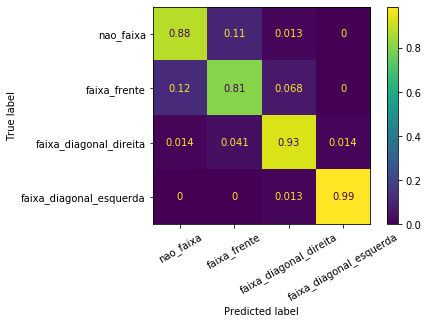

Rodada 1	-	Seed 6957
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.94      0.93        67
           faixa_frente       0.91      0.85      0.88        74
 faixa_diagonal_direita       0.88      0.96      0.92        79
faixa_diagonal_esquerda       0.99      0.95      0.97        80

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



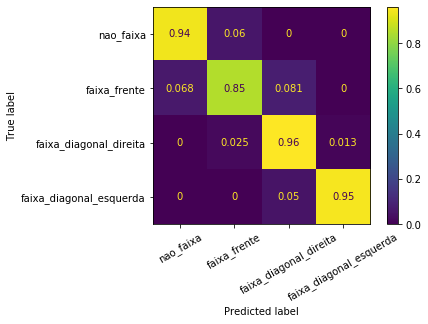

Rodada 2	-	Seed 7089
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.84      0.86        83
           faixa_frente       0.79      0.84      0.82        76
 faixa_diagonal_direita       0.96      0.90      0.93        78
faixa_diagonal_esquerda       0.94      1.00      0.97        63

               accuracy                           0.89       300
              macro avg       0.89      0.90      0.89       300
           weighted avg       0.89      0.89      0.89       300



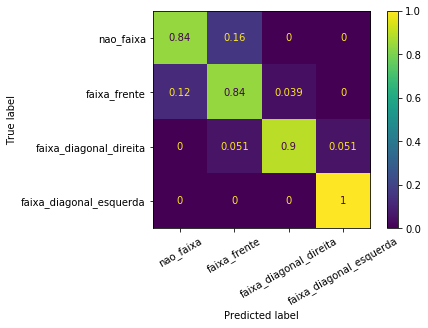

Rodada 3	-	Seed 1457
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.89      0.90        72
           faixa_frente       0.87      0.86      0.86        76
 faixa_diagonal_direita       0.92      0.97      0.95        72
faixa_diagonal_esquerda       1.00      0.99      0.99        80

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



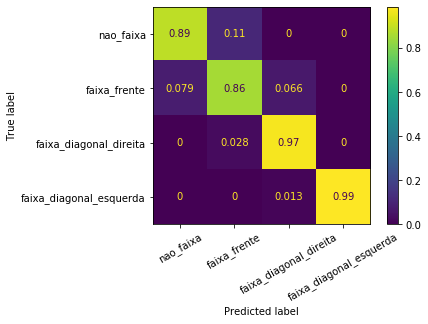

Rodada 4	-	Seed 5660
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.89      0.90        83
           faixa_frente       0.87      0.86      0.86        69
 faixa_diagonal_direita       0.94      1.00      0.97        64
faixa_diagonal_esquerda       1.00      0.99      0.99        84

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



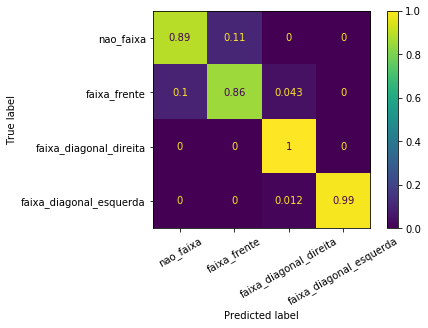

Rodada 5	-	Seed 1224
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.92      0.92        79
           faixa_frente       0.90      0.86      0.88        80
 faixa_diagonal_direita       0.92      0.94      0.93        70
faixa_diagonal_esquerda       0.97      0.99      0.98        71

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



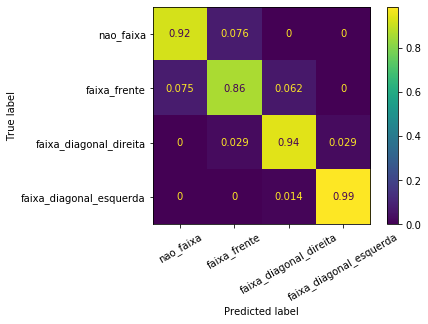

Rodada 6	-	Seed 3081
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.80      0.84        80
           faixa_frente       0.76      0.87      0.81        68
 faixa_diagonal_direita       0.96      0.93      0.94        71
faixa_diagonal_esquerda       0.98      0.98      0.98        81

               accuracy                           0.89       300
              macro avg       0.89      0.89      0.89       300
           weighted avg       0.90      0.89      0.89       300



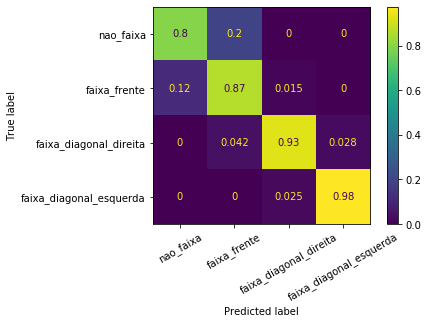

Rodada 7	-	Seed 5872
                         precision    recall  f1-score   support

              nao_faixa       0.87      0.93      0.90        76
           faixa_frente       0.86      0.81      0.83        77
 faixa_diagonal_direita       0.91      0.88      0.89        72
faixa_diagonal_esquerda       0.95      0.97      0.96        75

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.90      0.90      0.90       300



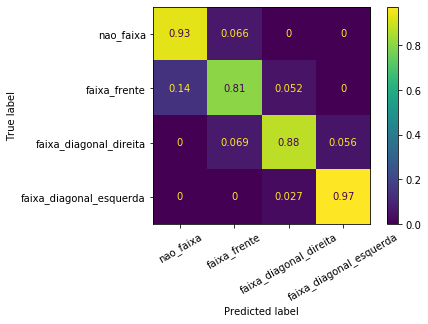

Rodada 8	-	Seed 4111
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.84      0.85        83
           faixa_frente       0.79      0.80      0.79        74
 faixa_diagonal_direita       0.86      0.95      0.91        66
faixa_diagonal_esquerda       1.00      0.92      0.96        77

               accuracy                           0.88       300
              macro avg       0.88      0.88      0.88       300
           weighted avg       0.88      0.88      0.88       300



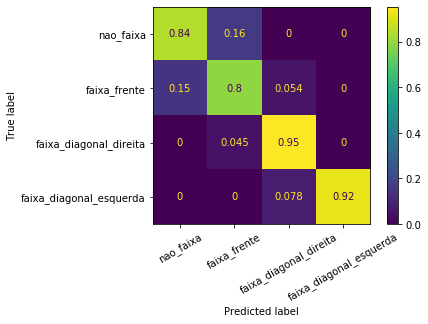

Rodada 9	-	Seed 4607
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.92      0.93        83
           faixa_frente       0.85      0.84      0.84        67
 faixa_diagonal_direita       0.89      0.93      0.91        73
faixa_diagonal_esquerda       0.99      0.99      0.99        77

               accuracy                           0.92       300
              macro avg       0.92      0.92      0.92       300
           weighted avg       0.92      0.92      0.92       300



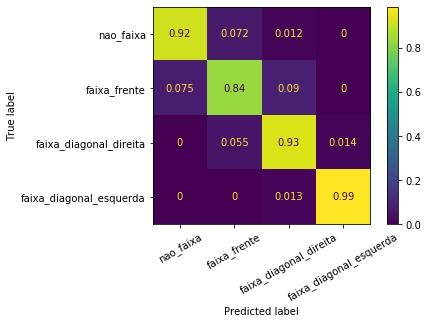

Rodada 10	-	Seed 4369
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.92      0.91        72
           faixa_frente       0.90      0.86      0.88        83
 faixa_diagonal_direita       0.93      0.96      0.95        73
faixa_diagonal_esquerda       0.99      1.00      0.99        72

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



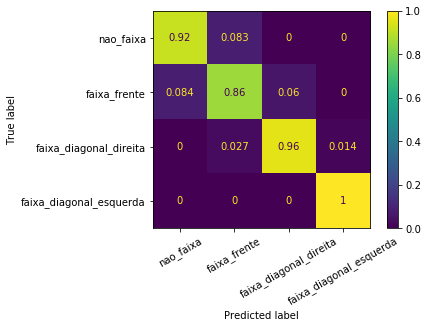

Rodada 11	-	Seed 7441
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.94      0.89        64
           faixa_frente       0.84      0.76      0.80        75
 faixa_diagonal_direita       0.89      0.90      0.89        86
faixa_diagonal_esquerda       0.97      0.96      0.97        75

               accuracy                           0.89       300
              macro avg       0.89      0.89      0.89       300
           weighted avg       0.89      0.89      0.89       300



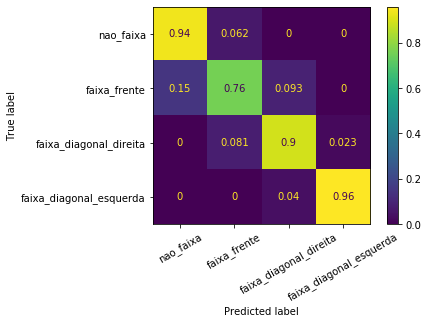

Rodada 12	-	Seed 383
                         precision    recall  f1-score   support

              nao_faixa       0.98      0.88      0.93        69
           faixa_frente       0.86      0.98      0.92        66
 faixa_diagonal_direita       0.97      0.93      0.95        84
faixa_diagonal_esquerda       0.96      0.98      0.97        81

               accuracy                           0.94       300
              macro avg       0.94      0.94      0.94       300
           weighted avg       0.95      0.94      0.94       300



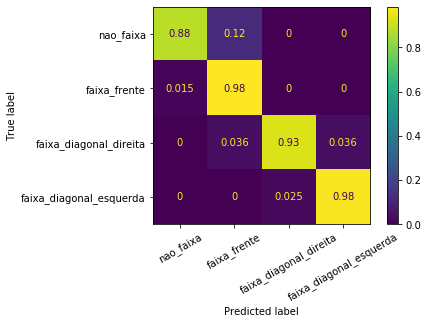

Rodada 13	-	Seed 4438
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.89      0.90        73
           faixa_frente       0.85      0.83      0.84        63
 faixa_diagonal_direita       0.93      0.97      0.95        79
faixa_diagonal_esquerda       0.99      0.99      0.99        85

               accuracy                           0.93       300
              macro avg       0.92      0.92      0.92       300
           weighted avg       0.93      0.93      0.93       300



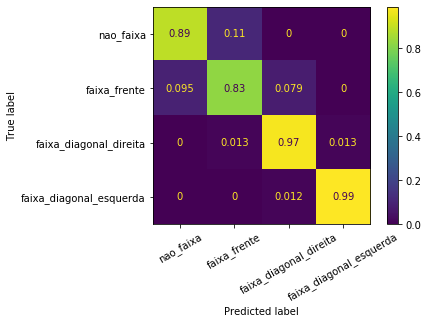

Rodada 14	-	Seed 1284
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.91      0.91        82
           faixa_frente       0.84      0.82      0.83        68
 faixa_diagonal_direita       0.90      0.90      0.90        67
faixa_diagonal_esquerda       0.96      0.98      0.97        83

               accuracy                           0.91       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.91      0.91      0.91       300



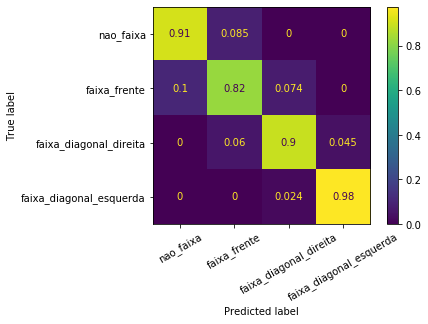

Rodada 15	-	Seed 4326
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.97      0.94        67
           faixa_frente       0.96      0.86      0.91        78
 faixa_diagonal_direita       0.94      0.99      0.96        76
faixa_diagonal_esquerda       1.00      1.00      1.00        79

               accuracy                           0.95       300
              macro avg       0.95      0.95      0.95       300
           weighted avg       0.95      0.95      0.95       300



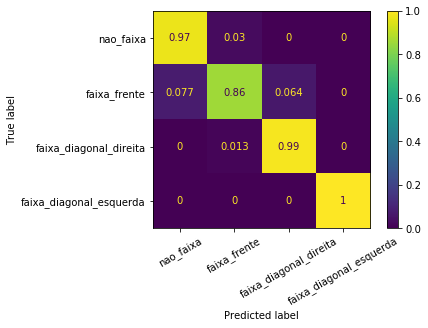

Rodada 16	-	Seed 3104
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.88      0.89        69
           faixa_frente       0.85      0.88      0.86        72
 faixa_diagonal_direita       0.93      0.92      0.93        89
faixa_diagonal_esquerda       0.96      0.96      0.96        70

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



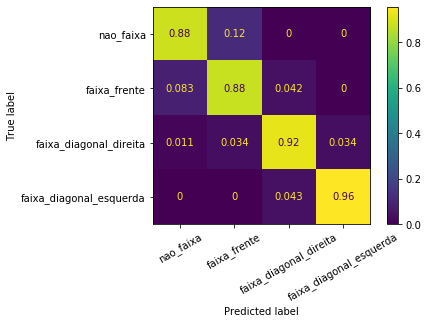

Rodada 17	-	Seed 2480
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.91      0.92        82
           faixa_frente       0.89      0.83      0.86        76
 faixa_diagonal_direita       0.91      0.96      0.93        72
faixa_diagonal_esquerda       0.97      1.00      0.99        70

               accuracy                           0.92       300
              macro avg       0.92      0.93      0.92       300
           weighted avg       0.92      0.92      0.92       300



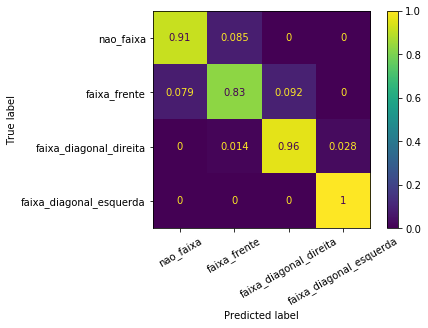

Rodada 18	-	Seed 5867
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.89      0.89        88
           faixa_frente       0.83      0.82      0.83        73
 faixa_diagonal_direita       0.95      0.92      0.93        77
faixa_diagonal_esquerda       0.95      1.00      0.98        62

               accuracy                           0.90       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.90      0.90      0.90       300



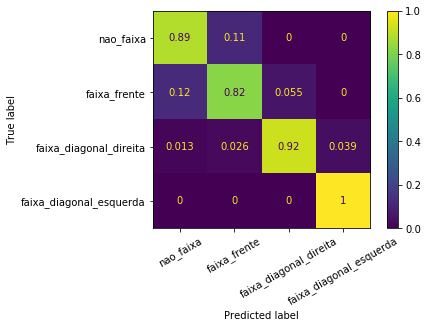

Rodada 19	-	Seed 4162
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.86      0.89        74
           faixa_frente       0.83      0.83      0.83        64
 faixa_diagonal_direita       0.89      0.95      0.92        81
faixa_diagonal_esquerda       0.97      0.95      0.96        81

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.90      0.90      0.90       300



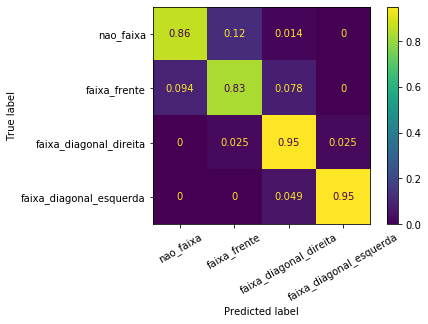

Rodada 20	-	Seed 4699
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.90      0.91        71
           faixa_frente       0.86      0.85      0.85        72
 faixa_diagonal_direita       0.92      0.95      0.93        73
faixa_diagonal_esquerda       0.99      0.99      0.99        84

               accuracy                           0.92       300
              macro avg       0.92      0.92      0.92       300
           weighted avg       0.92      0.92      0.92       300



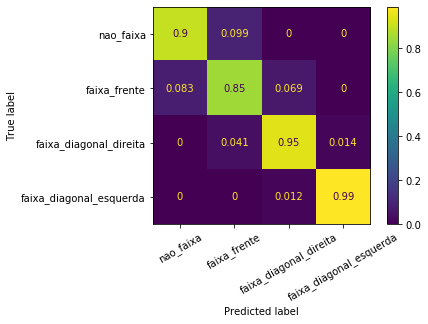

Rodada 21	-	Seed 7809
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.87      0.90        79
           faixa_frente       0.85      0.85      0.85        75
 faixa_diagonal_direita       0.91      0.96      0.93        74
faixa_diagonal_esquerda       0.97      0.97      0.97        72

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



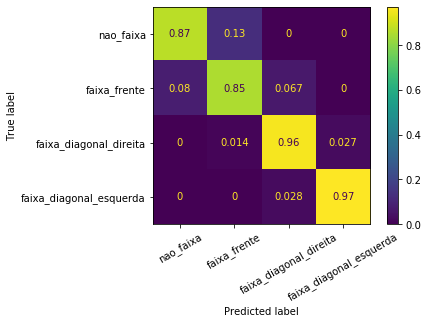

Rodada 22	-	Seed 2695
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.91      0.91        77
           faixa_frente       0.90      0.83      0.86        77
 faixa_diagonal_direita       0.91      0.93      0.92        73
faixa_diagonal_esquerda       0.94      0.99      0.96        73

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



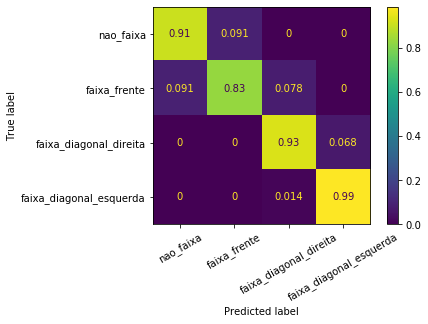

Rodada 23	-	Seed 4040
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.96      0.93        70
           faixa_frente       0.93      0.86      0.89        83
 faixa_diagonal_direita       0.93      0.97      0.95        72
faixa_diagonal_esquerda       1.00      1.00      1.00        75

               accuracy                           0.94       300
              macro avg       0.94      0.95      0.94       300
           weighted avg       0.94      0.94      0.94       300



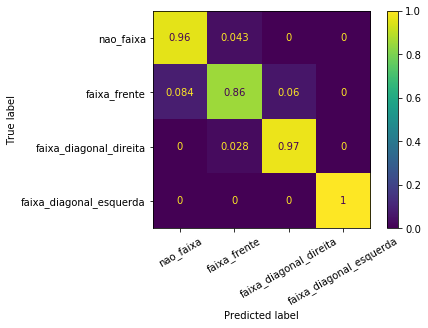

Rodada 24	-	Seed 5397
                         precision    recall  f1-score   support

              nao_faixa       0.88      0.91      0.89        75
           faixa_frente       0.87      0.80      0.84        76
 faixa_diagonal_direita       0.90      0.94      0.92        84
faixa_diagonal_esquerda       0.95      0.95      0.95        65

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.90      0.90      0.90       300



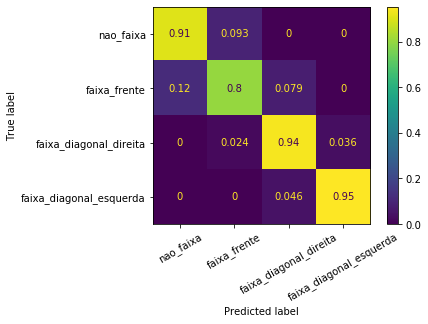

Rodada 25	-	Seed 6371
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.87      0.88        75
           faixa_frente       0.83      0.87      0.85        75
 faixa_diagonal_direita       0.95      0.92      0.93        76
faixa_diagonal_esquerda       0.96      0.99      0.97        74

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



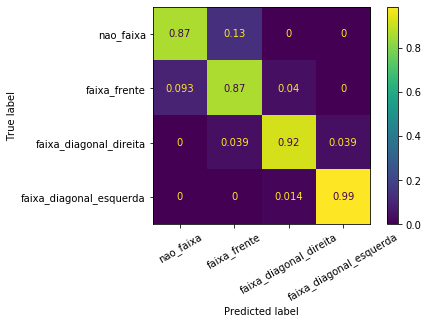

Rodada 26	-	Seed 550
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.93      0.93        70
           faixa_frente       0.93      0.87      0.90        86
 faixa_diagonal_direita       0.89      0.96      0.92        76
faixa_diagonal_esquerda       0.97      0.96      0.96        68

               accuracy                           0.93       300
              macro avg       0.93      0.93      0.93       300
           weighted avg       0.93      0.93      0.93       300



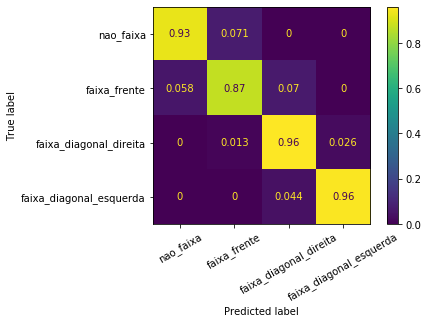

Rodada 27	-	Seed 6447
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.91      0.89        81
           faixa_frente       0.90      0.80      0.85        76
 faixa_diagonal_direita       0.89      0.92      0.91        73
faixa_diagonal_esquerda       0.94      0.96      0.95        70

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.90       300
           weighted avg       0.90      0.90      0.90       300



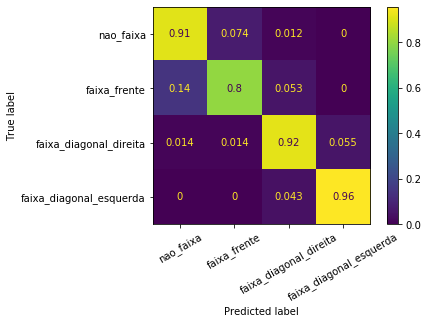

Rodada 28	-	Seed 5130
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.92      0.88        71
           faixa_frente       0.88      0.83      0.85        77
 faixa_diagonal_direita       0.97      0.88      0.92        72
faixa_diagonal_esquerda       0.93      1.00      0.96        80

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



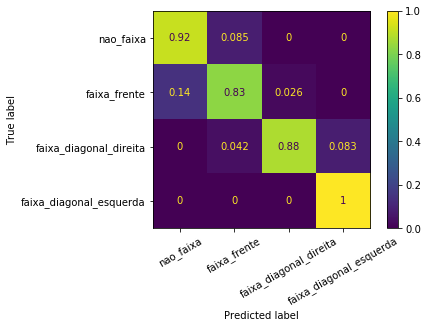

Rodada 29	-	Seed 6851
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.86      0.85        65
           faixa_frente       0.86      0.85      0.85        84
 faixa_diagonal_direita       0.95      0.93      0.94        75
faixa_diagonal_esquerda       0.99      1.00      0.99        76

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



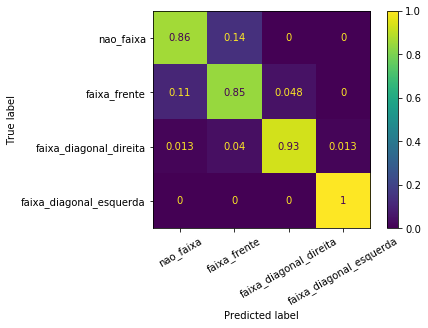

In [4]:
df = pd.read_csv('./csvs/otsu_inf-lbp_faixas.csv').tail(1000)
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

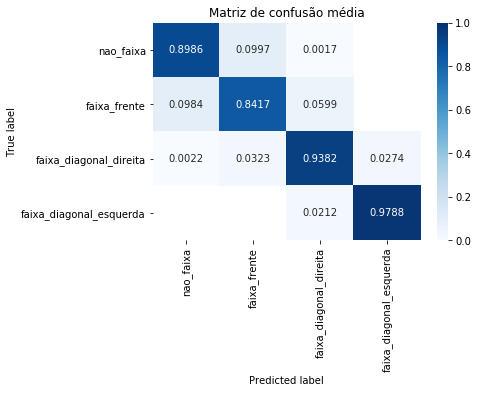

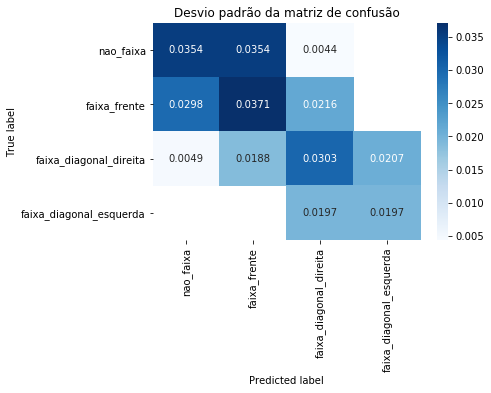

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-nao_faixa  f1-faixa_frente  f1-faixa_diagonal_direita  \
count  30.000000     30.000000        30.000000                  30.000000   
mean    0.914111      0.899122         0.851164                   0.928391   
std     0.017954      0.025254         0.030271                   0.019511   
min     0.876667      0.842105         0.791946                   0.890173   
25%     0.903333      0.886262         0.830276                   0.918683   
50%     0.911667      0.900071         0.851723                   0.928365   
75%     0.926667      0.918843         0.864402                   0.942042   
max     0.953333      0.942029         0.915493                   0.969697   

       f1-faixa_diagonal_esquerda  
count                   30.000000  
mean                     0.975367  
std                      0.014506  
min                      0.950355  
25%                      0.963186  
50%                      0.972778  
75%                      0.987907  
max      

Acurácia,f1-nao_faixa,f1-faixa_frente,f1-faixa_diagonal_direita,f1-faixa_diagonal_esquerda
0.903333,0.874172,0.825175,0.918919,0.987342
0.926667,0.933333,0.881119,0.921212,0.968153
0.890000,0.864198,0.815287,0.927152,0.969231
0.926667,0.901408,0.860927,0.945946,0.993711
0.933333,0.902439,0.861314,0.969697,0.994012
0.926667,0.924051,0.878981,0.929577,0.979021
0.893333,0.842105,0.808219,0.942857,0.975309
0.896667,0.898734,0.832215,0.893617,0.960526
0.876667,0.853659,0.791946,0.906475,0.959459
0.920000,0.926829,0.842105,0.912752,0.987013


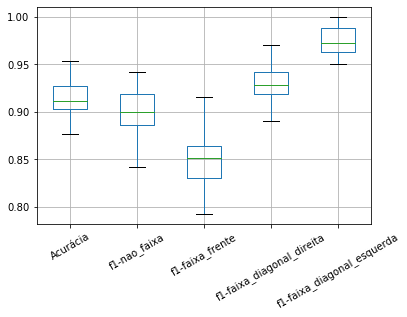

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')